# Garbage classification

https://www.kaggle.com/asdasdasasdas/garbage-classification

In [1]:
!pip install matplotlib
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

2.1.0
2.3.1


Using TensorFlow backend.


## Load train, test and val set txt file

1. glass
2. paper
3. cardboard
4. plastic
5. metal
6. trash

In [3]:
import pandas as pd

train_path = pd.read_table("Q:/glassification/one-indexed-files-notrash_train.txt", delimiter='\n',sep=" ", header=None)
val_path = pd.read_table("Q:/glassification/one-indexed-files-notrash_val.txt", delimiter='\n',sep=" ", header=None)
test_path = pd.read_table("Q:/glassification/one-indexed-files-notrash_test.txt", delimiter='\n',sep=" ", header=None)

In [4]:
train_path[['file_name','label']] = train_path[0].str.split(expand=True)
val_path[['file_name','label']] = val_path[0].str.split(expand=True)
test_path[['file_name','label']] = test_path[0].str.split(expand=True)

In [5]:
train_path.drop(columns=0,inplace=True)
val_path.drop(columns=0,inplace=True)
test_path.drop(columns=0,inplace=True)

## Prepare images path

In [6]:
def category(df_file_name):
    lst = []
    result = df_file_name.str.split('.',expand=True)
    result = result[0]
    for data in result:
        dt = ''.join([i for i in data if not i.isdigit()])
        lst.append(dt)
    return lst

#get category
cat_train = category(train_path['file_name'])
train_path = pd.concat((pd.Series(cat_train), train_path),axis=1)

cat_val = category(val_path['file_name'])
val_path = pd.concat((pd.Series(cat_val), val_path),axis=1)

cat_test = category(test_path['file_name'])
test_path = pd.concat((pd.Series(cat_test), test_path),axis=1)

In [7]:
train_path['full_path'] = "Q:/glassification/"+train_path[0]+"/"+train_path['file_name']
val_path['full_path'] = "Q:/glassification/"+val_path[0]+"/"+val_path['file_name']
test_path['full_path'] = "Q:/glassification/"+test_path[0]+"/"+test_path['file_name']

In [8]:
path_to_train = train_path['full_path'].values.tolist()
train_labels = train_path['label'].to_numpy().astype('int')

path_to_val = val_path['full_path'].values.tolist()
val_labels = val_path['label'].to_numpy().astype('int')

path_to_test = test_path['full_path'].values.tolist()
test_labels = test_path['label'].to_numpy().astype('int')

## Create datasets

In [28]:
import tensorflow as tf
import numpy as np


#read images
def read_images(filename):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32) / 255
    return image.numpy()


train = list(map(read_images, path_to_train))
val = list(map(read_images, path_to_val))
test = list(map(read_images, path_to_test))


In [29]:
train_x = np.array(train)
val_x = np.array(val)
test_x = np.array(test)

In [30]:
print(train_x.shape)
print(val_x.shape)
print(test_x.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(1768, 384, 512, 3)
(328, 384, 512, 3)
(431, 384, 512, 3)
(1768,)
(328,)
(431,)


In [31]:
train_labels_encoded = pd.get_dummies(train_labels).to_numpy()
val_labels_encoded = pd.get_dummies(val_labels).to_numpy()

## Train tensorflow model

In [71]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam

num_classes = 6
batch_size=32

model = keras.Sequential(
    [
        Conv2D(32, kernel_size=(3, 3), activation="relu",strides=(1,1),input_shape=(384, 512, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dropout(0.5),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

model.compile(loss="categorical_crossentropy",optimizer=Adam(learning_rate=0.001),metrics=["accuracy"])
history = model.fit(train_x, train_labels_encoded,epochs=50,validation_split=0.2,validation_data=(val_x, val_labels_encoded))

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 382, 510, 32)      896       
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 191, 255, 32)      0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 189, 253, 64)      18496     
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 94, 126, 64)       0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 92, 124, 64)       36928     
_________________________________________________________________
max_pooling2d_94 (MaxPooling (None, 46, 62, 64)        0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 44, 60, 64)      

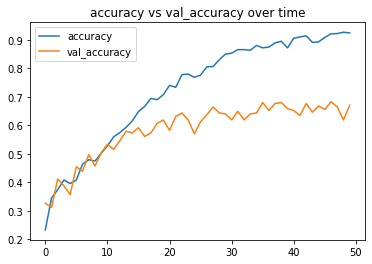

In [72]:
plt.plot(history.history['accuracy'], label="accuracy")
plt.plot(history.history['val_accuracy'], label="val_accuracy")
plt.title('accuracy vs val_accuracy over time')
plt.legend()

## Predict

In [73]:
prediction = model.predict(test_x)

In [74]:
y_pred = np.argmax(prediction, axis=1)

In [76]:
y_pred = y_pred + 1

In [77]:
print(f"score on test set : {(test_labels == y_pred).sum()/len(test_labels)}")

score on test set : 0.6357308584686775


### Results

>Train set accuracy : 92.48%

>Validation set accuracy : 67.07%

>Test set accuracy : 63.57%